<a href="https://colab.research.google.com/github/matteo-cutroni/CV-project/blob/main/Efficient_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [ ]:
!pip install torchmetrics[image]
import os
import json
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
from torchmetrics.image.fid import FrechetInceptionDistance
import matplotlib.pyplot as plt
from tqdm import tqdm
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Hyperparameters

In [ ]:
from torch.nn.modules import loss
drive_folder = '/content/drive/MyDrive/CV-project'
gen_path = os.path.join(drive_folder, "baseline_gen.pth")
disc_path = os.path.join(drive_folder, "baseline_disc.pth")
losses_path = os.path.join(drive_folder, "baseline_losses.json")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
LEARNING_RATE = 0.0002
BATCH_SIZE = 128
IMAGE_SIZE = 64         # resize CIFAR-10 to 64x64
CHANNELS_IMG = 3
Z_DIM = 100             # noise dimension
NUM_EPOCHS = 50
FEATURES_G = 64
FEATURES_D = 64

TEST_BATCH_SIZE = 100

# Utils

In [ ]:
def show_images(images):
    # reverse the normalization
    images = images * 0.5 + 0.5
    img_grid = make_grid(images, nrow=8)
    img_grid_np = img_grid.permute(1, 2, 0).cpu().numpy()

    plt.figure(figsize=(10, 10))
    plt.imshow(img_grid_np)
    plt.axis('off')
    plt.show()

def plot_losses(G_losses, D_losses, title="Training Losses"):
    plt.figure(figsize=(10, 5))
    plt.title(title)
    plt.plot(G_losses, label="Generator", alpha=0.7)
    plt.plot(D_losses, label="Discriminator", alpha=0.7)
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

# Dataset

In [ ]:
# normalize in range [-1.0, 1.0]
transforms = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(
        [0.5] * CHANNELS_IMG,
        [0.5] * CHANNELS_IMG
    )
])

dataset = datasets.CIFAR10(
    root="dataset/",
    train=True,
    transform=transforms,
    download=True
)

dataloader = DataLoader(
    dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2 # num_workers=2 is recommended by Colab
)

test_dataset = datasets.CIFAR10(
    root="dataset/",
    train=False,
    transform=transforms,
    download=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=TEST_BATCH_SIZE,
    shuffle=False
)

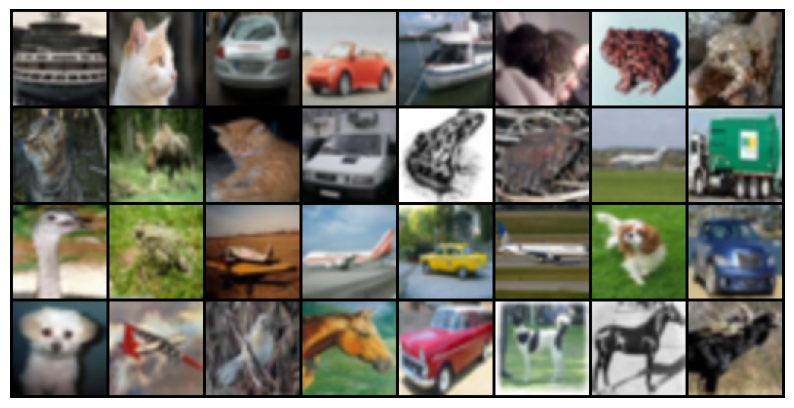

In [ ]:
real_batch = next(iter(dataloader))
images, labels = real_batch

show_images(images[:32])

# Network

In [ ]:
# same structure as DCGAN pytorch tutorial
class Discriminator(nn.Module):
    def __init__(self, channels_img, features_d):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(

            nn.Conv2d(channels_img, features_d, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),

            self._block(features_d, features_d * 2),
            self._block(features_d * 2, features_d * 4),
            self._block(features_d * 4, features_d * 8),

            nn.Conv2d(features_d * 8, 1, kernel_size=4, stride=1, padding=0),
            nn.Sigmoid()
        )

    def _block(self, in_channels, out_channels, kernel_size=4, stride=2, padding=1):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2)
        )

    def forward(self, x):
        return self.disc(x)

class Generator(nn.Module):
    def __init__(self, z_dim, channels_img, features_g):
        super(Generator, self).__init__()
        self.gen = nn.Sequential(

            self._block(z_dim, features_g * 16, 4, 1, 0),
            self._block(features_g * 16, features_g * 8, 4, 2, 1),
            self._block(features_g * 8, features_g * 4, 4, 2, 1),
            self._block(features_g * 4, features_g * 2, 4, 2, 1),

            nn.ConvTranspose2d(features_g * 2, channels_img, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )

    def forward(self, x):
        return self.gen(x)


def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)



gen = Generator(Z_DIM, CHANNELS_IMG, FEATURES_G).to(device)
disc = Discriminator(CHANNELS_IMG, FEATURES_D).to(device)
gen.apply(weights_init)
disc.apply(weights_init)

# using the paper's recommended parameters
opt_gen = optim.Adam(gen.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
opt_disc = optim.Adam(disc.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
criterion = nn.BCELoss()

fixed_noise = torch.randn(32, Z_DIM, 1, 1).to(device)

# Train

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [1/50] Loss D: 1.0236, Loss G: 2.3138


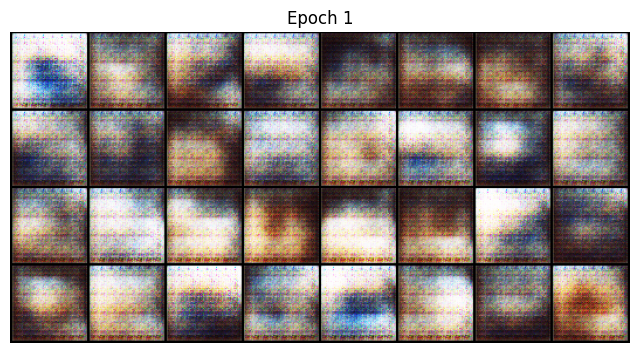

  4%|▍         | 2/50 [03:41<1:28:38, 110.81s/it]

Epoch [2/50] Loss D: 0.8331, Loss G: 1.5997


  6%|▌         | 3/50 [05:32<1:26:46, 110.78s/it]

Epoch [3/50] Loss D: 1.0338, Loss G: 1.7970


  8%|▊         | 4/50 [07:23<1:24:57, 110.81s/it]

Epoch [4/50] Loss D: 0.9583, Loss G: 1.6592
Epoch [5/50] Loss D: 1.1600, Loss G: 3.5403


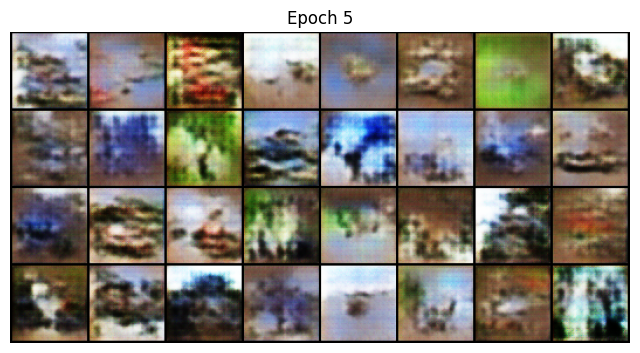

 12%|█▏        | 6/50 [11:05<1:21:19, 110.89s/it]

Epoch [6/50] Loss D: 0.6574, Loss G: 1.7041


 14%|█▍        | 7/50 [12:56<1:19:29, 110.92s/it]

Epoch [7/50] Loss D: 1.7915, Loss G: 5.5564


 16%|█▌        | 8/50 [14:46<1:17:35, 110.85s/it]

Epoch [8/50] Loss D: 0.1136, Loss G: 3.6597


 18%|█▊        | 9/50 [16:37<1:15:43, 110.83s/it]

Epoch [9/50] Loss D: 0.0513, Loss G: 8.5828
Epoch [10/50] Loss D: 0.5163, Loss G: 2.5618


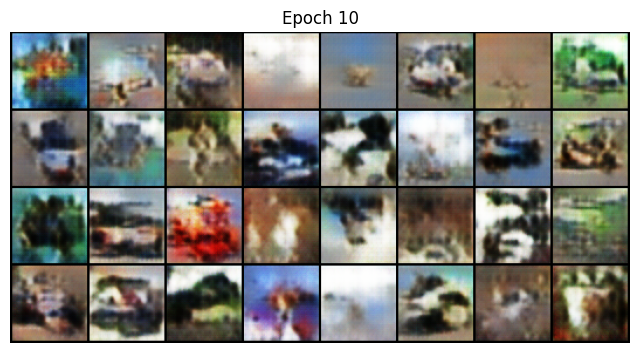

 22%|██▏       | 11/50 [20:19<1:11:59, 110.75s/it]

Epoch [11/50] Loss D: 0.0901, Loss G: 2.6635


 24%|██▍       | 12/50 [22:09<1:10:07, 110.73s/it]

Epoch [12/50] Loss D: 0.2111, Loss G: 3.2107


 26%|██▌       | 13/50 [24:00<1:08:17, 110.74s/it]

Epoch [13/50] Loss D: 0.6395, Loss G: 2.1127


 28%|██▊       | 14/50 [25:51<1:06:28, 110.78s/it]

Epoch [14/50] Loss D: 0.1199, Loss G: 4.9386
Epoch [15/50] Loss D: 0.8455, Loss G: 2.6840


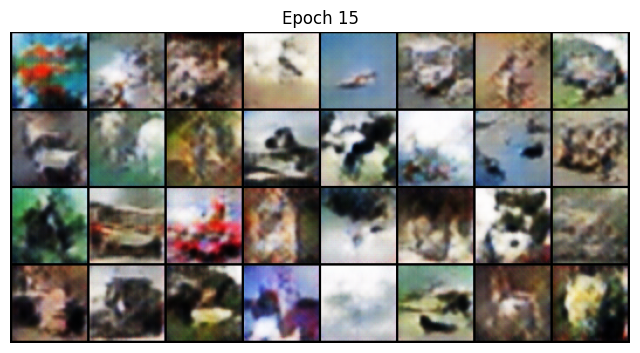

 32%|███▏      | 16/50 [29:33<1:02:50, 110.89s/it]

Epoch [16/50] Loss D: 0.6593, Loss G: 1.5828


 34%|███▍      | 17/50 [31:24<1:00:57, 110.85s/it]

Epoch [17/50] Loss D: 0.6747, Loss G: 2.4938


 36%|███▌      | 18/50 [33:14<59:05, 110.80s/it]  

Epoch [18/50] Loss D: 0.7100, Loss G: 1.4314


 38%|███▊      | 19/50 [35:05<57:11, 110.70s/it]

Epoch [19/50] Loss D: 0.0076, Loss G: 7.3592
Epoch [20/50] Loss D: 0.0209, Loss G: 4.8872


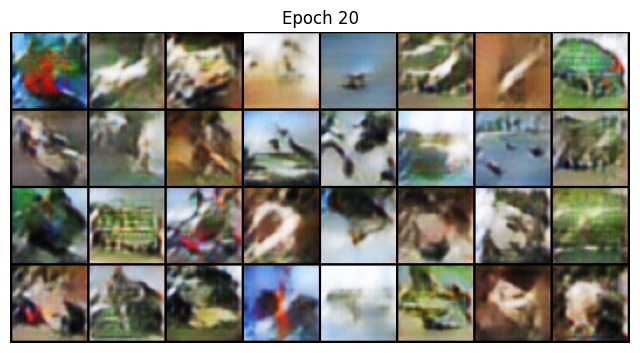

 42%|████▏     | 21/50 [38:46<53:28, 110.65s/it]

Epoch [21/50] Loss D: 0.0053, Loss G: 6.4626


 44%|████▍     | 22/50 [40:37<51:40, 110.72s/it]

Epoch [22/50] Loss D: 0.0173, Loss G: 5.1612


 46%|████▌     | 23/50 [42:28<49:48, 110.70s/it]

Epoch [23/50] Loss D: 0.6857, Loss G: 2.7781


 48%|████▊     | 24/50 [44:18<47:55, 110.58s/it]

Epoch [24/50] Loss D: 0.5421, Loss G: 2.8326
Epoch [25/50] Loss D: 0.4377, Loss G: 2.2441


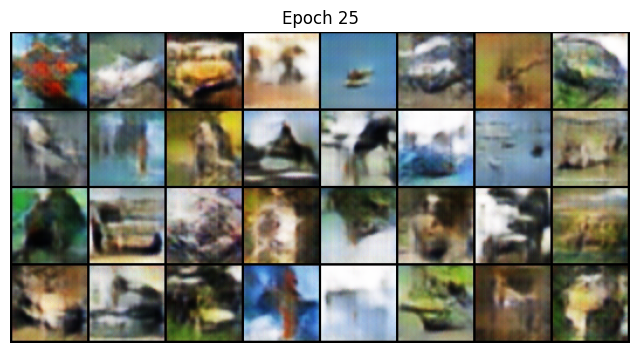

 52%|█████▏    | 26/50 [48:00<44:17, 110.74s/it]

Epoch [26/50] Loss D: 0.3995, Loss G: 3.1340


 54%|█████▍    | 27/50 [49:50<42:26, 110.72s/it]

Epoch [27/50] Loss D: 0.1577, Loss G: 3.7558


 56%|█████▌    | 28/50 [51:40<40:31, 110.51s/it]

Epoch [28/50] Loss D: 0.7135, Loss G: 3.4032


 58%|█████▊    | 29/50 [53:31<38:42, 110.57s/it]

Epoch [29/50] Loss D: 0.0135, Loss G: 6.7833
Epoch [30/50] Loss D: 0.0754, Loss G: 5.6697


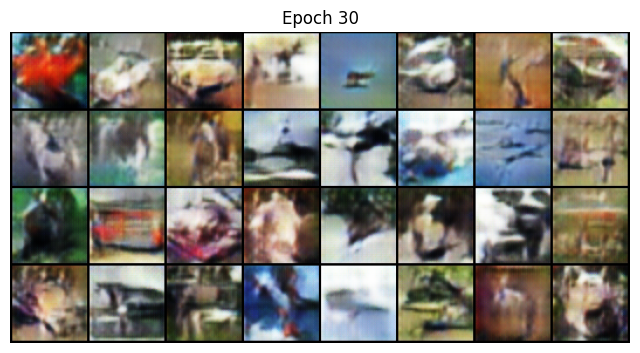

 62%|██████▏   | 31/50 [57:13<35:04, 110.77s/it]

Epoch [31/50] Loss D: 0.0109, Loss G: 6.0769


 64%|██████▍   | 32/50 [59:03<33:11, 110.64s/it]

Epoch [32/50] Loss D: 0.0011, Loss G: 7.7359


 66%|██████▌   | 33/50 [1:00:54<31:20, 110.63s/it]

Epoch [33/50] Loss D: 0.0002, Loss G: 14.8297


 68%|██████▊   | 34/50 [1:02:44<29:26, 110.42s/it]

Epoch [34/50] Loss D: 0.0004, Loss G: 8.1323
Epoch [35/50] Loss D: 0.0005, Loss G: 8.1199


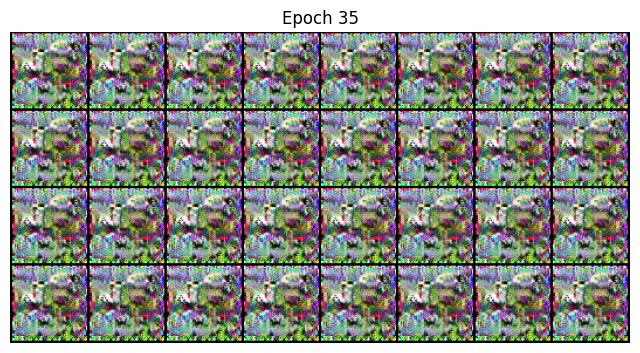

 72%|███████▏  | 36/50 [1:06:24<25:42, 110.17s/it]

Epoch [36/50] Loss D: 0.0001, Loss G: 20.1134


 74%|███████▍  | 37/50 [1:08:14<23:53, 110.23s/it]

Epoch [37/50] Loss D: 0.0004, Loss G: 18.9827


 76%|███████▌  | 38/50 [1:10:04<22:00, 110.07s/it]

Epoch [38/50] Loss D: 0.0000, Loss G: 40.8141


 78%|███████▊  | 39/50 [1:11:53<20:07, 109.76s/it]

Epoch [39/50] Loss D: 0.0000, Loss G: 40.4791
Epoch [40/50] Loss D: 0.0000, Loss G: 40.2438


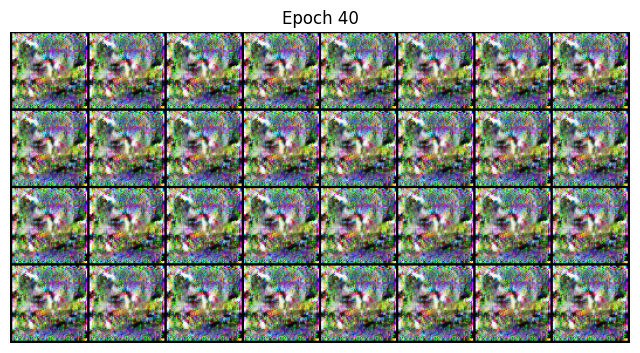

 82%|████████▏ | 41/50 [1:15:32<16:26, 109.62s/it]

Epoch [41/50] Loss D: 0.0000, Loss G: 40.0955


 84%|████████▍ | 42/50 [1:17:22<14:39, 109.88s/it]

Epoch [42/50] Loss D: 0.0000, Loss G: 39.8989


 86%|████████▌ | 43/50 [1:19:13<12:49, 109.93s/it]

Epoch [43/50] Loss D: 0.0000, Loss G: 39.7346


 88%|████████▊ | 44/50 [1:21:03<11:00, 110.00s/it]

Epoch [44/50] Loss D: 0.0000, Loss G: 39.6057
Epoch [45/50] Loss D: 0.0000, Loss G: 39.4285


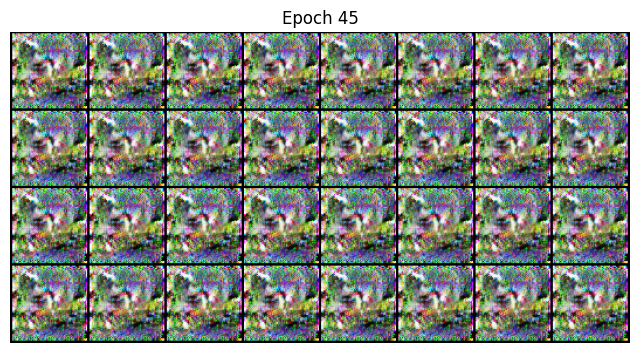

 92%|█████████▏| 46/50 [1:24:42<07:18, 109.73s/it]

Epoch [46/50] Loss D: 0.0000, Loss G: 39.2284


 94%|█████████▍| 47/50 [1:26:31<05:28, 109.64s/it]

Epoch [47/50] Loss D: 0.0000, Loss G: 38.9744


 96%|█████████▌| 48/50 [1:28:21<03:39, 109.67s/it]

Epoch [48/50] Loss D: 0.0000, Loss G: 38.6359


 98%|█████████▊| 49/50 [1:30:10<01:49, 109.64s/it]

Epoch [49/50] Loss D: 0.0000, Loss G: 38.0372
Epoch [50/50] Loss D: 0.0000, Loss G: 47.7575


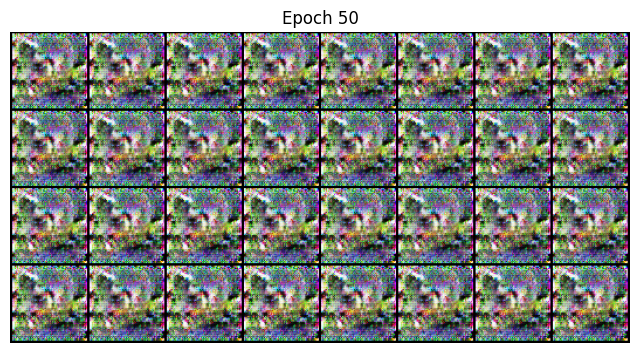

100%|██████████| 50/50 [1:32:00<00:00, 110.41s/it]


In [ ]:
img_list = []
G_losses = []
D_losses = []

for epoch in tqdm(range(NUM_EPOCHS)):
    for batch_idx, (real, _) in enumerate(dataloader):
        real = real.to(device)
        batch_size = real.shape[0]

        # Train Discriminator
        disc.zero_grad()

        # real data
        label = torch.ones((batch_size, 1, 1, 1)).to(device)
        output = disc(real)
        loss_d_real = criterion(output, label)
        loss_d_real.backward()

        # fake data
        noise = torch.randn(batch_size, Z_DIM, 1, 1).to(device)
        fake = gen(noise)
        label = torch.zeros((batch_size, 1, 1, 1)).to(device)
        output = disc(fake.detach()) # detach to avoid training generator on these gradients
        loss_d_fake = criterion(output, label)
        loss_d_fake.backward()

        loss_d = loss_d_real + loss_d_fake
        opt_disc.step()

        # Train Generator
        gen.zero_grad()
        label = torch.ones((batch_size, 1, 1, 1)).to(device) # disc thinks these are real
        output = disc(fake)
        loss_g = criterion(output, label)
        loss_g.backward()
        opt_gen.step()

        # save Losses for plotting later
        if batch_idx % 100 == 0:
            G_losses.append(loss_g.item())
            D_losses.append(loss_d.item())

    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}] Loss D: {loss_d:.4f}, Loss G: {loss_g:.4f}")

    # visualize progress every 5 epochs
    if (epoch + 1) % 5 == 0 or epoch == 0:
        with torch.no_grad():
            fake = gen(fixed_noise)
            # denormalize
            img_grid = make_grid(fake * 0.5 + 0.5, normalize=False)
            plt.figure(figsize=(8, 8))
            plt.axis("off")
            plt.title(f"Epoch {epoch+1}")
            plt.imshow(img_grid.permute(1, 2, 0).cpu().numpy())
            plt.show()

In [ ]:
# save baseline model
torch.save(gen.state_dict(), gen_path)
torch.save(disc.state_dict(), disc_path)

# save losses
with open(losses_path, 'w') as f:
    json.dump({"G": G_losses, "D": D_losses}, f)

# Test

In [ ]:
fid = FrechetInceptionDistance().to(device)

# load generator
gen_test = Generator(Z_DIM, CHANNELS_IMG, FEATURES_G).to(device)
gen_test.load_state_dict(torch.load(os.path.join(drive_folder, "baseline_gen.pth"), map_location=device))
gen_test.eval()

for i, (real_imgs, _) in enumerate(tqdm(test_loader, total=TEST_BATCH_SIZE, desc="real")):
    if i >= TEST_BATCH_SIZE: break

    real_imgs = real_imgs.to(device)

    # conversion for torchmetrics fid
    # denormalize [-1, 1] to [0, 1]
    real_imgs = (real_imgs * 0.5 + 0.5)
    # scale to [0, 255] and convert to uint8
    real_imgs = (real_imgs * 255).clamp(0, 255).to(dtype=torch.uint8)

    fid.update(real_imgs, real=True)


with torch.no_grad():
    for _ in tqdm(range(TEST_BATCH_SIZE), desc="fake"):

        noise = torch.randn(BATCH_SIZE, Z_DIM, 1, 1).to(device)
        fake_imgs = gen_test(noise)

        # conversion
        fake_imgs = (fake_imgs * 0.5 + 0.5)
        fake_imgs = (fake_imgs * 255).clamp(0, 255).to(dtype=torch.uint8)

        fid.update(fake_imgs, real=False)

fid_score = fid.compute()

print(f"FID Score: {fid_score.item():.4f}")

Downloading: "https://github.com/toshas/torch-fidelity/releases/download/v0.2.0/weights-inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/weights-inception-2015-12-05-6726825d.pth
100%|██████████| 91.2M/91.2M [00:00<00:00, 127MB/s]
fake: 100%|██████████| 100/100 [00:58<00:00,  1.71it/s]


FID Score: 424.5292


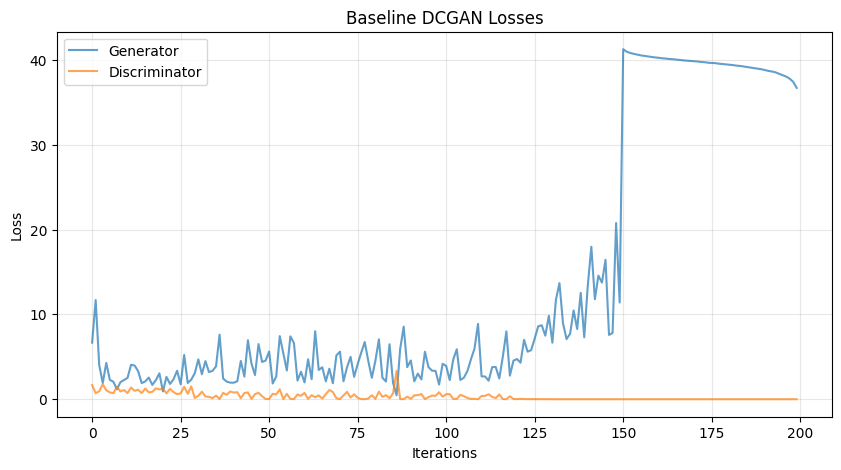

In [ ]:
with open(losses_path, 'r') as f:
    losses = json.load(f)

G_losses = losses["G"]
D_losses = losses["D"]

plot_losses(G_losses, D_losses, title="Baseline DCGAN Losses")